In [13]:
import os
os.chdir("/Users/rodrigoestebanantoniopizarroschwerter/projects/resto-ds-rappiflow/dags/analytics/")
print(os.getcwd())

import pandas as pd
import numpy as np
import seaborn as sns
from dotenv import dotenv_values
from utils import get_snowflake_data,pre_processing,quantile_analysis,regression_models
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


/Users/rodrigoestebanantoniopizarroschwerter/projects/resto-ds-rappiflow/dags/analytics


In [37]:
df = pd.read_csv("./retention_vs_exploration/data/df_regression.csv")


In [38]:
df.describe()

LOG_AVG_BAD_EXPERIENCE_SCORE  QUANT_ORDERS  LOG_POST_ORDERS  \
count                  84328.000000  84328.000000     84328.000000   
mean                       4.180923      6.295121         0.836236   
std                        0.538275      4.528424         0.924523   
min                        0.000000      3.000000         0.000000   
25%                        4.156276      3.000000         0.000000   
50%                        4.281285      5.000000         0.693147   
75%                        4.365220      7.000000         1.609438   
max                        5.119988     39.000000         3.433987   

       ORDERS_L365_DAYS  NEW_USER  CATEGORY_FIRST_ORDERS  \
count           84328.0   84328.0           84328.000000   
mean                0.0       1.0               3.011645   
std                 0.0       0.0               1.618003   
min                 0.0       1.0               1.000000   
25%                 0.0       1.0               2.000000   
50%                 0.0       1.0               3.000000   
75%                 0.0       1.0               4.000000   
max                 0.0       1.0              10.000000   

       FIRST_ORDERS_QUANTITY  COMPENSATION_RATE  \
count           84328.000000       84328.000000   
mean                4.220188           1.850006   
std                 2.546620           6.020106   
min                 1.000000           0.000000   
25%                 3.000000           0.000000   
50%                 3.000000           0.000000   
75%                 5.000000           0.000000   
max                15.000000          44.508671   

       DISTINCT_CATEGORIES_BEFORE_BP  CITY_NAME_is_null  ...  MONTH_6  \
count                        84328.0       84328.000000  ...  84328.0   
mean                             0.0           0.058842  ...      0.0   
std                              0.0           0.235330  ...      0.0   
min                              0.0           0.000000  ...      0.0   
25%                              0.0           0.000000  ...      0.0   
50%                              0.0           0.000000  ...      0.0   
75%                              0.0           0.000000  ...      0.0   
max                              0.0           1.000000  ...      0.0   

       MONTH_7       MONTH_8       MONTH_9  MONTH_10      MONTH_11  \
count  84328.0  84328.000000  84328.000000   84328.0  84328.000000   
mean       0.0      0.173430      0.131143       0.0      0.075610   
std        0.0      0.378621      0.337558       0.0      0.264374   
min        0.0      0.000000      0.000000       0.0      0.000000   
25%        0.0      0.000000      0.000000       0.0      0.000000   
50%        0.0      0.000000      0.000000       0.0      0.000000   
75%        0.0      0.000000      0.000000       0.0      0.000000   
max        0.0      1.000000      1.000000       0.0      1.000000   

           MONTH_12  ACQUISITION_SCORE  RETENTION_SCORE  REACTIVATION_SCORE  
count  84328.000000       84328.000000     84328.000000        84328.000000  
mean       0.093694           3.054122         4.186166            3.044137  
std        0.291404           1.585653         1.181594            1.603911  
min        0.000000           1.000000         1.000000            1.000000  
25%        0.000000           2.000000         4.000000            2.000000  
50%        0.000000           3.000000         5.000000            3.000000  
75%        0.000000           5.000000         5.000000            5.000000  
max        1.000000           5.000000         5.000000            5.000000  

[8 rows x 87 columns]

In [30]:
df = pd.read_csv("./retention_vs_exploration/data/df_regression_pre_logs.csv")

In [25]:
df[['AVG_BAD_EXPERIENCE_SCORE','POST_ORDERS']].min() == 0

AVG_BAD_EXPERIENCE_SCORE    True
POST_ORDERS                 True
dtype: bool

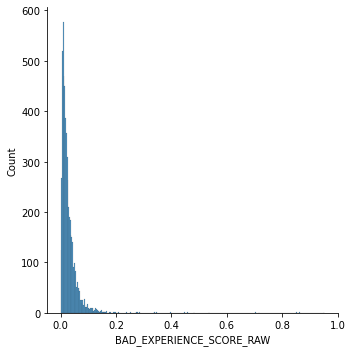

In [32]:
sns.displot(df_query[df_query['CITY_STORE_ORDERS']>100]['BAD_EXPERIENCE_SCORE_RAW'])

In [27]:
df_query[df_query['CITY_STORE_ORDERS']>100]['BAD_EXPERIENCE_SCORE_RAW'].quantile(.1)


0.006667

## Import Data
### Flag _import_data_as_csv_ for importing data from CSV or making the query to snowflake

In [11]:
import_data_as_csv = False
start_month = '2021-01-01'
end_month = '2021-10-01'

country = 'MX'
if import_data_as_csv:
    df_query = pd.read_csv(
        f'./retention_vs_exploration/data/{country}_start_month_{start_month}_end_month_{end_month}.csv', sep=";")
    df_nulls = pd.read_csv(
        f'./retention_vs_exploration/data/{country}_start_month_{start_month}_end_month_{end_month}_NULLS.csv', sep=";")
    print(df_nulls)
else:

    query = f"""
    with aux as (
    select *,
    month(first_order_month::date) as month,
    row_number() over (partition by application_user_id,days_initial_time_window order by first_order_month::date asc) as rn
    from events_home_restaurants.analytics_retention_vs_exploration
    where 1=1
    and (first_order_month <= '{end_month}' and first_order_month >= '{start_month}' )
    and country = '{country}'
    qualify rn= 1
    )

    select *
    from aux 

    """

    snowflake_connector = get_snowflake_data.SnowflakeConnector()
    df_query, df_nulls = snowflake_connector.get_pandas_dataframe_from_query(query, fillna_0=False, get_null_df=True)
    # df_query.to_csv(f'./retention_vs_exploration/data/{country}_start_month_{start_month}_end_month_{end_month}.csv',index=False,sep=";")
    # df_nulls.to_csv(f'./retention_vs_exploration/data/{country}_start_month_{start_month}_end_month_{end_month}_NULLS.csv',index=False,sep=";")


Amount of Nulls:
                            COLUMN  AMOUNT_OF_NULLS  PERC_OF_NULLS
9               COMPENSATION_RATE          2025633   8.563831e-01
1                      MEAN_SCORE           934296   3.949952e-01
19  DISTINCT_CATEGORIES_BEFORE_BP           232116   9.813240e-02
8                ORDERS_L365_DAYS           232116   9.813240e-02
17                       TIER_RCT           188479   7.968385e-02
18                FIRST_MICROZONE            62859   2.657509e-02
3                          AVG_FS            40582   1.715698e-02
0                       CITY_NAME            30868   1.305016e-02
15                       CATEGORY            20565   8.694329e-03
4           AVG_STORE_DEFECT_RATE             6254   2.644023e-03
5           AVG_STORE_CANCEL_RATE             5874   2.483369e-03
10           FIRST_BRAND_CATEGORY             2929   1.238302e-03
14                    SEGMENT_RFM             1433   6.058338e-04
16                    ULTRA_SCORE             1433   6.058

In [12]:
df_query.describe()

DAYS_INITIAL_TIME_WINDOW  APPLICATION_USER_ID      NEW_USER  \
count                 2365335.0         2.365335e+06  2.365335e+06   
mean                       90.0         1.325525e+09  3.479998e-01   
std                         0.0         1.149448e+09  4.763360e-01   
min                        90.0         2.014000e+03  0.000000e+00   
25%                        90.0         2.390120e+08  0.000000e+00   
50%                        90.0         2.989971e+08  0.000000e+00   
75%                        90.0         2.420493e+09  1.000000e+00   
max                        90.0         8.891164e+09  1.000000e+00   

       DIFFERENT_BRANDS  QUANT_ORDERS       TICKETS    MEAN_SCORE  \
count      2.365335e+06  2.365335e+06  2.365335e+06  1.431039e+06   
mean       4.276693e+00  6.883414e+00  1.762790e-01  4.380583e+00   
std        3.499553e+00  7.424591e+00  6.560121e-01  1.037033e+00   
min        0.000000e+00  3.000000e+00  0.000000e+00  0.000000e+00   
25%        2.000000e+00  3.000000e+00  0.000000e+00  4.000000e+00   
50%        3.000000e+00  4.000000e+00  0.000000e+00  5.000000e+00   
75%        5.000000e+00  7.000000e+00  0.000000e+00  5.000000e+00   
max        7.800000e+01  5.000000e+02  9.900000e+01  5.000000e+00   

       QUANT_REVIEWS  BAD_EXP_ORDERS  QUANT_DISTINCT_CATEGORIES  ...  \
count   2.365335e+06    2.365335e+06               2.365335e+06  ...   
mean    1.603552e+00    1.023910e-01               3.404684e+00  ...   
std     2.643088e+00    3.926241e-01               2.026862e+00  ...   
min     0.000000e+00    0.000000e+00               0.000000e+00  ...   
25%     0.000000e+00    0.000000e+00               2.000000e+00  ...   
50%     1.000000e+00    0.000000e+00               3.000000e+00  ...   
75%     2.000000e+00    0.000000e+00               4.000000e+00  ...   
max     1.390000e+02    1.700000e+01               2.300000e+01  ...   

       AVG_BES_V5_DEFECTS_ONLY  AVG_BES_V6_DELAY_ONLY  \
count             2.365335e+06           2.365335e+06   
mean              8.383013e-03           4.104829e-03   
std               4.630424e-03           5.397630e-03   
min               0.000000e+00           0.000000e+00   
25%               5.263500e-03           1.169333e-03   
50%               7.504667e-03           2.506000e-03   
75%               1.044725e-02           5.040000e-03   
max               1.294610e-01           2.685580e-01   

       AVG_BES_V7_CANCELED_ONLY  AVG_BES_V8_DEFECTED_CANCELED  \
count              2.365335e+06                  2.365335e+06   
mean               2.351838e-03                  1.073430e-02   
std                3.396002e-03                  6.316683e-03   
min                0.000000e+00                  0.000000e+00   
25%                5.963333e-04                  6.606000e-03   
50%                1.324000e-03                  9.417512e-03   
75%                2.772750e-03                  1.325300e-02   
max                2.198950e-01                  2.303660e-01   

       AVG_BES_V9_DEFECTED_CANCELED_BAD_REVIEW  \
count                             2.365335e+06   
mean                              2.291946e-02   
std                               1.147626e-02   
min                               0.000000e+00   
25%                               1.507675e-02   
50%                               2.075850e-02   
75%                               2.820735e-02   
max                               2.984290e-01   

       AVG_BES_V10_ALL_ORDERS_NO_REPURCHASE  \
count                          2.365335e+06   
mean                           3.400563e-02   
std                            1.649306e-02   
min                            0.000000e+00   
25%                            2.283200e-02   
50%                            3.088433e-02   
75%                            4.146300e-02   
max                            4.013150e-01   

       AVG_BES_V11_ALL_ORDERS_CANCELED_DEFECTED  \
count                              2.365335e+06   
mean                        

In [4]:
op_variables = ['AVG_EQS', 'AVG_FS']

users_scope = ['ALL_USERS', 'NEW_USERS', 'NON_NEW_USERS', 'HEAVY_USERS']

numerical_user_features = [
    'ACQUISITION_SCORE',
    'RETENTION_SCORE',
    'REACTIVATION_SCORE',
    'AGE_IN_RAPPI_IN_MONTHS',
    'DISTINCT_CATEGORIES_BEFORE_BP'
]

invalid_values_numerical_user_features = [
    'ACQUISITION_SCORE',
    'RETENTION_SCORE',
    'REACTIVATION_SCORE',
]

categorical_columns = [
    'COUNTRY'
]

df_query = pre_processing.get_dummies_by_rank_based_in_quantile(df_query,
                                                                columns_to_dummie=[
                                                                    'FIRST_MICROZONE'],
                                                                columns_to_count=['APPLICATION_USER_ID'],
                                                                quantile=10,
                                                                duplicates='drop')
print("Shape post get_dummies_by_rank_based_in_quantile", df_query.shape)

df_query['PCT_FIRST_ORDERS'] = df_query['FIRST_ORDERS_QUANTITY']/df_query['QUANT_ORDERS']
df_query['PCT_FIRST_ORDERS'] = df_query['PCT_FIRST_ORDERS'].fillna(0)

df_query['AVG_ERROR_ETA_EARLY'] = df_query['AVG_ETA_FROM_START'] - df_query['AVG_ORDER_TIME']
df_query['AVG_ERROR_ETA_LATE'] = df_query['AVG_ORDER_TIME'] - df_query['AVG_ETA_FROM_START']

df_query.loc[df_query.loc[:, 'AVG_ERROR_ETA_EARLY'] < 0, 'AVG_ERROR_ETA_EARLY'] = 0

df_query.loc[df_query.loc[:, 'AVG_ERROR_ETA_LATE'] < 0, 'AVG_ERROR_ETA_LATE'] = 0

# Conversion de EQS
for col in df_query.columns:
    if 'EQS' in col:
        df_query[col] = np.abs((100/170)*df_query[col])
df_nulls = df_nulls[df_nulls['COLUMN'] != 'ORDERS_L365_DAYS']

# Columnas con flag en variables con nulos
df_query = pre_processing.boolean_on_nan_columns(df_query, df_nulls, fillna_0=False)

# Dropeo variables con alta dimensionalidad (no me da la RAM)
drop_categoricals = ['COUNTRY']

df_categorical_dummies = pre_processing.dummies_and_concat(df_query, categorical_columns, drop_categoricals)
print("Shape post dummies_and_concat", df_categorical_dummies.shape)

# Add categorical dummmies
categorical_vars = []
for var in categorical_columns:
    for col in df_categorical_dummies.columns:
        if var in col:
            categorical_vars.append(col)

regression_variables_list = [
    'QUANT_ORDERS',
    'POST_ORDERS',
    'ORDERS_L365_DAYS',
    'NEW_USER',
    'PCT_FIRST_ORDERS',
    'FIRST_ORDER_CATEGORY_RATE',
    'COMPENSATION_RATE',
    'AVG_BAD_EXPERIENCE_SCORE',
    'DISTINCT_CATEGORIES_BEFORE_BP'
]

regression_variables_list.extend(categorical_vars)

regression_variables_list.extend(numerical_user_features)

variables_to_log = [
    'POST_ORDERS',
    'PCT_FIRST_ORDERS',
    'FIRST_ORDER_CATEGORY_RATE',
    'AVG_BAD_EXPERIENCE_SCORE'
]

pct_variables = [
    'PCT_FIRST_ORDERS',
    # 'USER_CANCEL_RATE',
    'FIRST_ORDER_CATEGORY_RATE',
    # 'AVG_STORE_DEFECT_RATE',
    # 'AVG_STORE_CANCEL_RATE',
    'COMPENSATION_RATE',
    'AVG_BAD_EXPERIENCE_SCORE'
    #'BAD_REVIEWS_RATE'
]
print("Shape before pct_variables", df_categorical_dummies.shape)
for pct_var in pct_variables:
    df_categorical_dummies = df_categorical_dummies.loc[(
        df_categorical_dummies[pct_var] <= 1) & (df_categorical_dummies[pct_var] >= 0), :]
    df_categorical_dummies.loc[:, pct_var] = df_categorical_dummies.loc[:, pct_var]*100
print("Shape post pct_variables", df_categorical_dummies.shape)

for var in invalid_values_numerical_user_features:
    df_categorical_dummies = df_categorical_dummies.loc[df_categorical_dummies[var] > 0, :]
print("Shape post invalid_values_numerical_user_features", df_categorical_dummies.shape)

df = df_categorical_dummies

df = pre_processing.delete_outliers_by_percentiles(
                df,
                columns_with_outliers=[
                    'QUANT_ORDERS',
                    'POST_ORDERS',
                    # 'AVG_ERROR_ETA_LATE',
                    # 'AVG_ERROR_ETA_EARLY',
                    # 'USER_CANCEL_RATE',
                    'COMPENSATION_RATE'
                    # 'AVG_ORDER_TIME',
                    ],
                percentile=0.99
            )
print("Shape post delete_outliers_by_percentiles", df.shape)

df['ORDERS_L365_DAYS'].fillna(0, inplace=True)



df_regression = df[regression_variables_list].fillna({
                                                    'FIRST_ORDERS_QUANTITY': 0
                                                    })

Shape post get_dummies_by_rank_based_in_quantile (1563300, 47)
Shape post dummies_and_concat (1563300, 68)
Shape before pct_variables (1563300, 68)
Shape post pct_variables (1496375, 68)
Shape post invalid_values_numerical_user_features (1494447, 68)
Shape post delete_outliers_by_percentiles (1451542, 68)


In [5]:
a = df_regression.describe()

## Filters

Hard coded filters to divide the scope of the analysis

In [8]:
op_variables = ['AVG_EQS', 'AVG_FS', 'AVG_STORE_DEFECT_RATE', 'AVG_STORE_CANCEL_RATE', 'AVG_ORDER_TIME',
                'AVG_ETA_FROM_START', 'AVG_ERROR_ETA_EARLY', 'AVG_ERROR_ETA_LATE', 'BAD_EXP_ORDERS', 
                'USER_CANCEL_RATE','BAD_REVIEWS_RATE']

users_scope = ['ALL_USERS', 'NEW_USERS', 'NON_NEW_USERS', 'HEAVY_USERS']

columns_with_not_valid_values = ['FIRST_DEVICE_SCORE', 'ZONE_SCORE', 'FIRST_GMV_SCORE']

numerical_user_features = ['LTV_6_MONTHS',
                            'LAST_GMV_SCORE',
                            'RECENCY',
                            'FREQUENCY',
                            'FIRST_PAID_REACTIVATION',
                            'LAST_DEVICE_SCORE',
                            'FIRST_DISCOUNT_REACTIVATION',
                            'FIRST_DISCOUNT_ASSUMED_ALLY',
                            'FIRST_DISCOUNT_ACTIVATION',
                            'SCORE_HVU',
                            'REGISTER_GMV_SCORE',
                            'FIRST_TOTAL_VALUE',
                            'REGISTER_SCORE_DEVICE',
                            'FIRST_DISCOUNT_RAPPI_PAY',
                            'MEDIA_COST',
                            'FIRST_DISCOUNT_COMPENSATION',
                            'MONETARY',
                            'FIRST_DISCOUNT_ASSUMED_RAPPI',
                            'LOOK_ALIKE_SCORE',
                            'FIRST_PAID_ACTIVATION',
                            'SEG_MEAN_FREQUENCY',
                            'SEG_MEAN_RECENCY',
                            'FIRST_DISCOUNT_RAPPI_PRIME',
                            'PRIORITIZATION_SCORE',
                            'SEG_MEAN_MONETARY',
                            'FIRST_TOTAL_DISCOUNT',
                            'TIER_RCT',
                            'DAYS_SINCE_LAST_ORDER']

invalid_values_numerical_user_features = [
    'LTV_6_MONTHS',
    'RECENCY',
    'FREQUENCY',
    'LAST_DEVICE_SCORE',
    'SCORE_HVU',
    'REGISTER_SCORE_DEVICE',
    'MONETARY',
    'LOOK_ALIKE_SCORE',
    'FIRST_PAID_ACTIVATION',
    'SEG_MEAN_FREQUENCY',
    'SEG_MEAN_RECENCY',
    'PRIORITIZATION_SCORE',
    # 'NUM_APP_LAUNCH_LST_30_D',
    'SEG_MEAN_MONETARY',
]
columns_with_not_valid_values = ['FIRST_DEVICE_SCORE', 'ZONE_SCORE', 'FIRST_GMV_SCORE']
columns_with_not_valid_values.extend(invalid_values_numerical_user_features)

# Add null dummies columns
null_columns = ['MEAN_SCORE_is_null', 'FIRST_ORDER_EQS_is_null', 'FIRST_ORDER_FS_is_null',
                'AVG_FIRST_STORE_ORDER_FS_is_null', 'AVG_FIRST_STORE_ORDER_EQS_is_null', 
                'REGISTER_GMV_SCORE_is_null', 'LAST_GMV_SCORE_is_null']

categorical_columns = [
    'COUNTRY', 'FIRST_OS', 'CITY_NAME', 'FIRST_BRAND_CATEGORY', 'GENDER',
    'CATEGORY',
    'TYPE_USER',
    'SEGMENT_RFM',
    'REGISTER_DEVICE',
    'FIRST_DEVICE',
    'LAST_DEVICE',
    'LAST_ORDER_TYPE',
    'LAST_PAYMENT_METHOD',
    'LAST_OS',
    'REGISTER_OS',
    'FIRST_VERTICAL',
    'FIRST_CITY',
    'LAST_MICROZONE_RANK',
    'FIRST_MICROZONE_RANK',
    'MATURITY',
    'FIRST_PAYMENT_METHOD',
    'OS_LAST_EVENT_RAKAM',
    'CHURN',
    'CC_BLOCKED', 'IS_PRIME', 'PUSH_MARKETING', 'MAILINGS', 'MONTH', 'FIRST_ORDER_MONTH'
]


df_query = pre_processing.get_dummies_by_rank_based_in_quantile(df_query,
                                                                columns_to_dummie=[
                                                                    'FIRST_MICROZONE', 'LAST_MICROZONE'],
                                                                columns_to_count=['APPLICATION_USER_ID',
                                                                                    'APPLICATION_USER_ID'],
                                                                quantile=10)

# Variable de dias desde ultima compra
timedelta = pd.to_datetime('2022-05-18 22:36:56-05:00', utc=True) - \
    pd.to_datetime(df_query['LAST_ORDER_AT'], format='%Y-%m-%d', utc=True)
df_query['DAYS_SINCE_LAST_ORDER'] = timedelta.apply(lambda x:  x.days)
df_query['PCT_FIRST_ORDERS'] = df_query['FIRST_ORDERS_QUANTITY']/df_query['QUANT_ORDERS']
df_query['PCT_FIRST_ORDERS'] = df_query['PCT_FIRST_ORDERS'].fillna(0)

df_query['AVG_ERROR_ETA_EARLY'] = df_query['AVG_ETA_FROM_START'] - df_query['AVG_ORDER_TIME']
df_query['AVG_ERROR_ETA_LATE'] = df_query['AVG_ORDER_TIME'] - df_query['AVG_ETA_FROM_START']

df_query.loc[df_query.loc[:, 'AVG_ERROR_ETA_EARLY'] < 0, 'AVG_ERROR_ETA_EARLY'] = 0

df_query.loc[df_query.loc[:, 'AVG_ERROR_ETA_LATE'] < 0, 'AVG_ERROR_ETA_LATE'] = 0

# Conversion de EQS
for col in df_query.columns:
    if 'EQS' in col:
        df_query[col] = np.abs((100/170)*df_query[col])
df_nulls = df_nulls[df_nulls['COLUMN'] != 'ORDERS_L365_DAYS']



In [9]:
df_query.shape

(2568956, 116)

In [10]:
# Columnas con flag en variables con nulos
df_query = pre_processing.boolean_on_nan_columns(df_query, df_nulls, fillna_0=False)

# Columnas con flag en variables numericas con valores no validos
df_query = pre_processing.boolean_on_non_valid_values_columns(df_query, columns_with_not_valid_values, -1
                                                                )

# Dropeo variables con alta dimensionalidad (no me da la RAM)
drop_categoricals = ['COUNTRY', 'OS_LAST_EVENT_RAKAM', 'FIRST_DEVICE',
                        'REGISTER_DEVICE', 'LAST_DEVICE', 'FIRST_ORDER_MONTH']

df_categorical_dummies = pre_processing.dummies_and_concat(df_query, categorical_columns, drop_categoricals)


    

/Users/rodrigoestebanantoniopizarroschwerter/projects/resto-ds-rappiflow/dags/resto_ds/analytics/utils/pre_processing.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[:,f'{null_col}_is_not_valid'] = 0
/Users/rodrigoestebanantoniopizarroschwerter/projects/resto-ds-rappiflow/dags/resto_ds/analytics/utils/pre_processing.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[:,f'{null_col}_is_not_valid'] = 0
/Users/rodrigoestebanantoniopizarroschwerter/projects/resto-ds-rappiflow/dags/resto_ds/analytics/utils/pre_pro

In [11]:
df_query.shape

(2568956, 217)

In [13]:
# Add categorical dummmies
categorical_vars = []
for var in categorical_columns:
    for col in df_categorical_dummies.columns:
        if var in col:
            categorical_vars.append(col)
# Add non valid dummies
non_valid_vars = []
for var in columns_with_not_valid_values:
    for col in df_categorical_dummies.columns:
        if var in col:
            non_valid_vars.append(col)

regression_variables_list = [
    'DIFFERENT_BRANDS',
    'QUANT_ORDERS',
    'TICKETS',
    'ZONE_SCORE',
    'FIRST_GMV_SCORE',
    'BRANDS_WITH_2_ORDERS_OR_MORE',
    'QUANT_DISTINCT_CATEGORIES',
    'MEAN_SCORE',
    'POST_ORDERS',
    'ORDERS_L365_DAYS',
    'NEW_USER',
    'DAYS_SINCE_LAST_ORDER',
    'PCT_FIRST_ORDERS',
    'FIRST_ORDER_CATEGORY_RATE',
    'COMPENSATION_RATE'
]

regression_variables_list.extend(categorical_vars)
regression_variables_list.extend(non_valid_vars)
regression_variables_list.extend(numerical_user_features)

variables_to_log = [
    'POST_ORDERS',
    'PCT_FIRST_ORDERS',
    'FIRST_ORDER_CATEGORY_RATE',
    'COMPENSATION_RATE'
]

pct_variables = [
    'PCT_FIRST_ORDERS',
    'USER_CANCEL_RATE',
    'FIRST_ORDER_CATEGORY_RATE',
    'AVG_STORE_DEFECT_RATE',
    'AVG_STORE_CANCEL_RATE',
    'COMPENSATION_RATE',
    'BAD_REVIEWS_RATE'
]

print("Shape pre pct_variables",df_categorical_dummies.shape)
for pct_var in pct_variables:
    df_categorical_dummies = df_categorical_dummies[df_categorical_dummies[pct_var]<=1]
    df_categorical_dummies = df_categorical_dummies[df_categorical_dummies[pct_var]>=0]
    df_categorical_dummies[pct_var] = df_categorical_dummies[pct_var]*100
print("Shape post pct_variables",df_categorical_dummies.shape)

df = df_categorical_dummies
df = df[df['NEW_USER'] == 1]
print("Shape before delete_outliers_by_percentiles", df.shape)
# Outliers y errores en datos
df = pre_processing.delete_outliers_by_percentiles(
    df,
    columns_with_outliers=[
        'QUANT_ORDERS',
        'POST_ORDERS',
        'AVG_ERROR_ETA_LATE',
        'AVG_ERROR_ETA_EARLY',
        'USER_CANCEL_RATE',
        'DIFFERENT_BRANDS',
        'QUANT_DISTINCT_CATEGORIES',
        'COMPENSATION_RATE'],
    percentile=0.99
            )
print("Shape after delete_outliers_by_percentiles", df.shape)

df = pre_processing.filter_columns_higher_than_zero(
    df,
    columns_to_filter=[
        'DIFFERENT_BRANDS',
        'QUANT_DISTINCT_CATEGORIES',
        'COMPENSATION_RATE']
)

print(df.shape)
            

Shape pre pct_variables (2568956, 447)
Shape post pct_variables (2556558, 447)
Shape before delete_outliers_by_percentiles (993773, 447)
Shape after delete_outliers_by_percentiles (925024, 447)
(87218, 447)


In [16]:

op_var = 'AVG_EQS'
regression_variables = regression_variables_list.copy()


regression_variables.insert(0, op_var)
variables_to_log.insert(0, op_var)

# initialize a null list
unique_list = []

for x in regression_variables:
    # check if exists in unique_list or not
    if x not in unique_list:
        unique_list.append(x)
regression_variables = unique_list

df_regression = df[regression_variables].fillna({'TICKETS': 0,
                                                    'FIRST_ORDERS_QUANTITY': 0,
                                                    'BRANDS_WITH_2_ORDERS_OR_MORE': 0
                                                    })
print("Size:" ,df_regression.shape)
for reg_var in regression_variables:
    df_regression[reg_var] = pd.to_numeric(df_regression[reg_var], errors='coerce')
print("Size:" ,df_regression.shape)
nulls = df_regression.isna().sum()
quant = nulls/len(df_regression)
df_nulls = pd.DataFrame({
    'COLUMN': nulls.index,
    'AMOUNT_OF_NULLS': nulls,
    'PERC_OF_NULLS': quant
})
df_nulls = df_nulls[df_nulls['AMOUNT_OF_NULLS'] > 0].reset_index(drop=True)
df_nulls.sort_values(by='PERC_OF_NULLS', ascending=False, inplace=True)
print("Amount of Nulls:\n", df_nulls)

df_regression.replace([np.inf, -np.inf], np.nan, inplace=True)
df_regression.dropna(inplace=True)
print("Size:" ,df_regression.shape)

Size: (87218, 360)
Size: (87218, 360)
Amount of Nulls:
                   COLUMN  AMOUNT_OF_NULLS  PERC_OF_NULLS
4     REGISTER_GMV_SCORE            39918       0.457681
3         LAST_GMV_SCORE            30355       0.348036
0             MEAN_SCORE            16969       0.194558
1      LAST_DEVICE_SCORE              351       0.004024
5               TIER_RCT               73       0.000837
2  REGISTER_SCORE_DEVICE                1       0.000011
Size: (29218, 360)


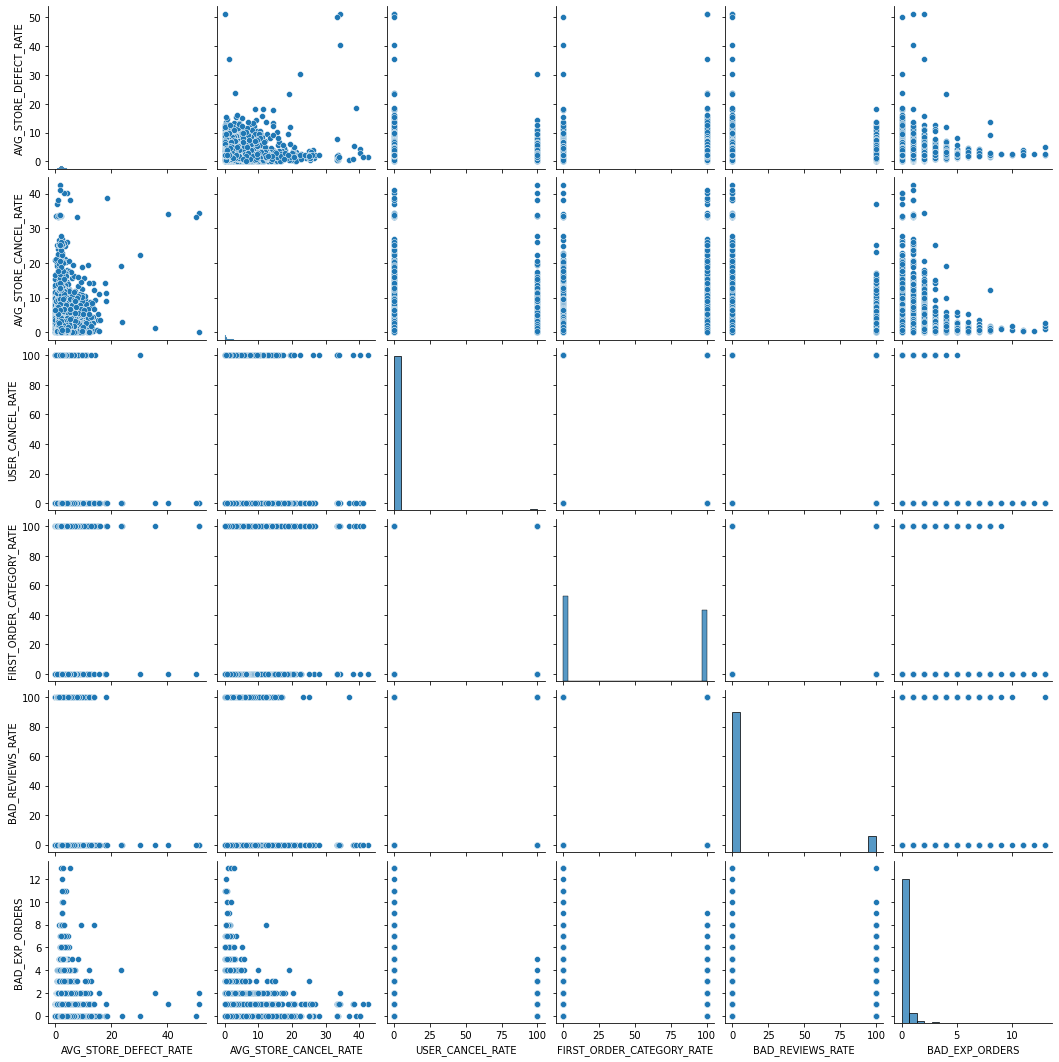

In [ ]:
sns.pairplot(df_query[[
 'AVG_STORE_DEFECT_RATE',
 'AVG_STORE_CANCEL_RATE',
 'USER_CANCEL_RATE',
 'FIRST_ORDER_CATEGORY_RATE',
 'BAD_REVIEWS_RATE',
 'BAD_EXP_ORDERS'
 ]].sample(frac = 0.1))

/opt/anaconda3/envs/analytics/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='USER_CANCELED_ORDER', ylabel='Density'>

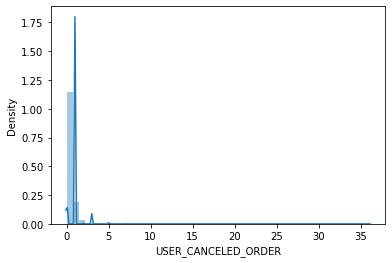

In [ ]:
sns.distplot(df_query['USER_CANCELED_ORDER'])

## Categorical Columns and outliers

In [ ]:
df_query['USER_CANCELED_ORDERS']

KeyError: 'USER_CANCELED_ORDERS'

In [ ]:
df = df[df.QUANT_ORDERS > 0]
df = df[df.QUANT_ORDERS <= 140 ]
df = df[df.DIFFERENT_BRANDS >0 ]
df = df[df.QUANT_DISTINCT_CATEGORIES >0 ]

In [ ]:
df['ORDERS_L365_DAYS'].fillna(0,inplace=True)

#EQS Values transformed to [0,100] range
for col in df.columns:
    if 'EQS' in col:
        df[col]=np.abs((100/170)*df[col])

In [ ]:
df_nulls = df_nulls[df_nulls['COLUMN']!='ORDERS_L365_DAYS']
df_nulls

COLUMN  AMOUNT_OF_NULLS  PERC_OF_NULLS
0                     POST_MEAN_SCORE           125858       0.562499
1             NUM_APP_LAUNCH_LST_30_D            72900       0.325813
2                          MEAN_SCORE            69205       0.309299
3                  REGISTER_GMV_SCORE            54063       0.241625
4                      LAST_GMV_SCORE            37112       0.165865
5                      FIRST_ORDER_FS            33811       0.151112
6             FIRST_ORDER_DEFECT_RATE            17193       0.076841
7                     FIRST_ORDER_EQS            16690       0.074593
8                FIRST_BRAND_CATEGORY             9047       0.040434
9                           STDDEV_FS             6716       0.030016
11           AVG_FIRST_STORE_ORDER_FS             3118       0.013935
12                             MAX_FS             2623       0.011723
13                             AVG_FS             2623       0.011723
14                             MIN_FS             2623       0.011723
15                     LAST_MICROZONE              780       0.003486
16                  LAST_DEVICE_SCORE              753       0.003365
17                        LAST_DEVICE              753       0.003365
18                            LAST_OS              753       0.003365
19                         STDDEV_EQS              299       0.001336
20                    FIRST_MICROZONE              188       0.000840
21              REGISTER_SCORE_DEVICE              164       0.000733
22                    REGISTER_DEVICE              164       0.000733
23                          CITY_NAME              151       0.000675
24  AVG_FIRST_STORE_ORDER_DEFECT_RATE               51       0.000228
25              AVG_STORE_CANCEL_RATE               51       0.000228
26              AVG_STORE_DEFECT_RATE               51       0.000228
27          AVG_FIRST_STORE_ORDER_EQS               49       0.000219
28                            MAX_EQS               49       0.000219
29                            MIN_EQS               49       0.000219
30                            AVG_EQS               49       0.000219
31                         FIRST_CITY               48       0.000215
32                     FIRST_VERTICAL               12       0.000054
33                           TIER_RCT                4       0.000018

In [ ]:
timedelta =  pd.to_datetime('2022-05-10 22:36:56-05:00')  - pd.to_datetime(df['LAST_ORDER_AT'],format='%Y-%m-%d') 
df['DAYS_SINCE_LAST_ORDER']=timedelta.apply(lambda x :  x.days)

In [ ]:
df = pre_processing.boolean_on_nan_columns(df,df_nulls,fillna_0=True)

In [ ]:
columns_with_not_valid_values = ['FIRST_DEVICE_SCORE','ZONE_SCORE','FIRST_GMV_SCORE']
columns_with_not_valid_values.extend(invalid_values_numerical_user_features)
df = pre_processing.boolean_on_non_valid_values_columns(df, columns_with_not_valid_values,-1,)



In [ ]:
df.columns

Index(['COUNTRY', 'DAYS_INITIAL_TIME_WINDOW', 'APPLICATION_USER_ID',
       'NEW_USER', 'CITY_NAME', 'FIRST_ORDER_MONTH', 'DIFFERENT_BRANDS',
       'QUANT_ORDERS', 'TICKETS', 'MEAN_SCORE',
       ...
       'SCORE_HVU_is_not_valid', 'REGISTER_SCORE_DEVICE_is_not_valid',
       'MONETARY_is_not_valid', 'LOOK_ALIKE_SCORE_is_not_valid',
       'FIRST_PAID_ACTIVATION_is_not_valid', 'SEG_MEAN_FREQUENCY_is_not_valid',
       'SEG_MEAN_RECENCY_is_not_valid', 'PRIORITIZATION_SCORE_is_not_valid',
       'NUM_APP_LAUNCH_LST_30_D_is_not_valid',
       'SEG_MEAN_MONETARY_is_not_valid'],
      dtype='object', length=163)

In [ ]:
categorical_columns = [
    'COUNTRY'
    ,'FIRST_OS'
    ,'FIRST_MICROZONE'
    ,'CITY_NAME'
    ,'FIRST_BRAND_CATEGORY'
    ,'GENDER',
 'CATEGORY',
 'TYPE_USER',
 'SEGMENT_RFM',
 'REGISTER_DEVICE',
 'FIRST_DEVICE',
 'LAST_DEVICE',
 'LAST_ORDER_TYPE',
 'LAST_PAYMENT_METHOD',
 'LAST_OS',
 'REGISTER_OS',
 'FIRST_VERTICAL',
 'FIRST_CITY',
 'LAST_MICROZONE',
 'MATURITY',
 'FIRST_PAYMENT_METHOD',
 'OS_LAST_EVENT_RAKAM',
 'CHURN',
 'CC_BLOCKED', 'IS_PRIME', 'PUSH_MARKETING', 'MAILINGS'
]
drop_categoricals = ['COUNTRY','LAST_MICROZONE','FIRST_MICROZONE','OS_LAST_EVENT_RAKAM','FIRST_DEVICE','REGISTER_DEVICE','LAST_DEVICE']
for  cat in categorical_columns:
    print(cat,len(df[cat].unique()))
df_categorical_dummies = pre_processing.dummies_and_concat(df, categorical_columns , drop_categoricals)

df_categorical_dummies

COUNTRY 1
FIRST_OS 6
FIRST_MICROZONE 224
CITY_NAME 36
FIRST_BRAND_CATEGORY 31
GENDER 4
CATEGORY 4
TYPE_USER 5
SEGMENT_RFM 7
REGISTER_DEVICE 2937
FIRST_DEVICE 2825
LAST_DEVICE 2025
LAST_ORDER_TYPE 2
LAST_PAYMENT_METHOD 9
LAST_OS 6
REGISTER_OS 3
FIRST_VERTICAL 14
FIRST_CITY 39
LAST_MICROZONE 261
MATURITY 4
FIRST_PAYMENT_METHOD 13
OS_LAST_EVENT_RAKAM 3
CHURN 5
CC_BLOCKED 2
IS_PRIME 2
PUSH_MARKETING 2
MAILINGS 2


DAYS_INITIAL_TIME_WINDOW  APPLICATION_USER_ID  NEW_USER  \
0                             90           1312078346         1   
1                             90           1311483325         0   
2                             90             18607550         1   
3                             90            136302501         1   
4                             90            151269248         0   
...                          ...                  ...       ...   
223743                        90           1413137603         1   
223744                        90            104846964         0   
223745                        90           1110715731         1   
223746                        90            124385760         1   
223747                        90            125752061         1   

       FIRST_ORDER_MONTH  DIFFERENT_BRANDS  QUANT_ORDERS  TICKETS  MEAN_SCORE  \
0             2021-06-01                 4             7        1         4.0   
1             2021-08-01                 4             4        0         3.0   
2             2021-03-01                 8            19        0         0.0   
3             2021-07-01                17            35        1         4.0   
4             2021-01-01                 1             4        0         0.0   
...                  ...               ...           ...      ...         ...   
223743        2021-10-01                20            31        0         0.0   
223744        2021-06-01                 2             3        0         0.0   
223745        2021-02-01                 3             8        3         0.0   
223746        2021-10-01                 3             3        0         0.0   
223747        2021-06-01                 3             3        0         0.0   

        QUANT_REVIEWS  BAD_EXP_ORDERS  ...  LAST_DEVICE_ZTE BLADE A610  \
0                   4               2  ...                           0   
1                   3               3  ...                           0   
2                   0               0  ...                           0   
3                   3               7  ...                           0   
4                   0               0  ...                           0   
...               ...             ...  ...                         ...   
223743              0              14  ...                           0   
223744              0               1  ...                           0   
223745              0               0  ...                           0   
223746              0               3  ...                           0   
223747              0               2  ...                           0   

        LAST_DEVICE_ZTE BLADE A7 2019  LAST_DEVICE_ZTE BLADE A7 2020  \
0                                   0                              0   
1                                   0                              0   
2                                   0                              0   
3                                   0                              0   
4                                   0                              0   
...                               ...                            ...   
223743                              0                              0   
223744                              0                              0   
223745                              0                              0   
223746                              0                              0   
223747                              0                              0   

        LAST_DEVICE_ZTE BLADE L210  LAST_DEVICE_ZTE BLADE L8  \
0                                0                         0   
1                                0                         0   
2                                0                         0   
3                                0                         0   
4                                0                         0   
...                            ...                       ...   
223743                      

In [ ]:
categorical_vars = []
for var in categorical_columns:
    for col in df_categorical_dummies.columns:
        if 'FIRST_VERTICAL' in col:
            categorical_vars.append(col)
categorical_vars

['FIRST_VERTICAL_is_null',
 'FIRST_VERTICAL_0',
 'FIRST_VERTICAL_ANTOJOS',
 'FIRST_VERTICAL_CPGS',
 'FIRST_VERTICAL_DONATION',
 'FIRST_VERTICAL_E-COMMERCE',
 'FIRST_VERTICAL_GRIN',
 'FIRST_VERTICAL_OTROS',
 'FIRST_VERTICAL_PARTNERSHIPS',
 'FIRST_VERTICAL_RAPPI',
 'FIRST_VERTICAL_RAPPI TRAVEL',
 'FIRST_VERTICAL_RAPPICASH',
 'FIRST_VERTICAL_RAPPIFAVOR',
 'FIRST_VERTICAL_RESTAURANTES',
 'FIRST_VERTICAL_UNKNOW',
 'FIRST_VERTICAL_is_null',
 'FIRST_VERTICAL_0',
 'FIRST_VERTICAL_ANTOJOS',
 'FIRST_VERTICAL_CPGS',
 'FIRST_VERTICAL_DONATION',
 'FIRST_VERTICAL_E-COMMERCE',
 'FIRST_VERTICAL_GRIN',
 'FIRST_VERTICAL_OTROS',
 'FIRST_VERTICAL_PARTNERSHIPS',
 'FIRST_VERTICAL_RAPPI',
 'FIRST_VERTICAL_RAPPI TRAVEL',
 'FIRST_VERTICAL_RAPPICASH',
 'FIRST_VERTICAL_RAPPIFAVOR',
 'FIRST_VERTICAL_RESTAURANTES',
 'FIRST_VERTICAL_UNKNOW',
 'FIRST_VERTICAL_is_null',
 'FIRST_VERTICAL_0',
 'FIRST_VERTICAL_ANTOJOS',
 'FIRST_VERTICAL_CPGS',
 'FIRST_VERTICAL_DONATION',
 'FIRST_VERTICAL_E-COMMERCE',
 'FIRST_VERTICAL_GR

In [ ]:
print(df_categorical_dummies.columns)

Index(['DAYS_INITIAL_TIME_WINDOW', 'APPLICATION_USER_ID', 'NEW_USER',
       'FIRST_ORDER_MONTH', 'DIFFERENT_BRANDS', 'QUANT_ORDERS', 'TICKETS',
       'MEAN_SCORE', 'QUANT_REVIEWS', 'BAD_EXP_ORDERS',
       ...
       'FIRST_BRAND_CATEGORY_Poke', 'FIRST_BRAND_CATEGORY_Pollo',
       'FIRST_BRAND_CATEGORY_Postres', 'FIRST_BRAND_CATEGORY_Saludables',
       'FIRST_BRAND_CATEGORY_Sushi', 'FIRST_BRAND_CATEGORY_Sándwiches',
       'FIRST_BRAND_CATEGORY_Tacos', 'FIRST_BRAND_CATEGORY_Vegetariana',
       'FIRST_BRAND_CATEGORY_Wings', 'FIRST_BRAND_CATEGORY_Árabe'],
      dtype='object', length=148)


In [ ]:
categorical_vars = []
for var in categorical_columns:
    for col in df_categorical_dummies.columns:
        if var in col:
            categorical_vars.append(col)
categorical_vars

['FIRST_OS_AND-WEB',
 'FIRST_OS_ANDROID',
 'FIRST_OS_IOS',
 'FIRST_OS_IOS-WEB',
 'FIRST_OS_UNDEFINED OS',
 'FIRST_OS_WEB',
 'FIRST_MICROZONE_is_null',
 'FIRST_MICROZONE_0',
 'FIRST_MICROZONE_AEROPUERTO',
 'FIRST_MICROZONE_Acopi CLO',
 'FIRST_MICROZONE_Aeropuerto PEI',
 'FIRST_MICROZONE_Alamos BOG3',
 'FIRST_MICROZONE_Alamos norte BOG4',
 'FIRST_MICROZONE_Alfaguara - Jamundi',
 'FIRST_MICROZONE_Alto de las Palmas',
 'FIRST_MICROZONE_Americas / Techo BOG6',
 'FIRST_MICROZONE_BARRANQUILLA NOR OCCIDENTE',
 'FIRST_MICROZONE_BARRANQUILLA SUR',
 'FIRST_MICROZONE_BIMA BOG',
 'FIRST_MICROZONE_Barrancabermeja',
 'FIRST_MICROZONE_Bazzar 80 y Retorno',
 'FIRST_MICROZONE_Belen MDE1',
 'FIRST_MICROZONE_Bello Norte',
 'FIRST_MICROZONE_Bello Sur',
 'FIRST_MICROZONE_Boca y Castillo Grande CTG4',
 'FIRST_MICROZONE_Bomberos',
 'FIRST_MICROZONE_Bosa',
 'FIRST_MICROZONE_Boston CTG',
 'FIRST_MICROZONE_Briseño',
 'FIRST_MICROZONE_Britalia Santa Carolina BOG2',
 'FIRST_MICROZONE_Buga',
 'FIRST_MICROZONE_CENTR

## Description of data

In [ ]:
df[['AVG_STORE_DEFECT_RATE'
    ,'AVG_EQS'
    , 'STDDEV_EQS'
    , 'MIN_EQS'
    , 'MAX_EQS'
    , 'AVG_FS'
    , 'STDDEV_FS'
    , 'MIN_FS'
    , 'MAX_FS'
    , 'FIRST_ORDER_EQS'
    , 'FIRST_ORDER_FS'
    , 'FIRST_ORDER_DEFECT_RATE'
    ,  'AVG_FIRST_STORE_ORDER_EQS'
    , 'AVG_FIRST_STORE_ORDER_FS'
    ,  'AVG_FIRST_STORE_ORDER_DEFECT_RATE']].describe()

AVG_STORE_DEFECT_RATE       AVG_EQS    STDDEV_EQS       MIN_EQS  \
count           94270.000000  94270.000000  94270.000000  94270.000000   
mean                0.022683     63.842865     18.645104     90.341990   
std                 0.007064     11.214536      8.142548     14.795594   
min                 0.000000      0.000000      0.000000      0.000000   
25%                 0.017918     54.905729     15.091234     89.100000   
50%                 0.022068     64.087417     19.747472     97.000000   
75%                 0.026831     71.912500     23.897486    100.000000   
max                 0.104999    100.000000     49.099994    100.000000   

            MAX_EQS        AVG_FS     STDDEV_FS        MIN_FS        MAX_FS  \
count  94270.000000  94270.000000  94270.000000  94270.000000  94270.000000   
mean      24.891616      0.785029      0.455651      0.137965      1.632366   
std       20.388397      0.455269      0.276671      0.242057      0.895580   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.506278      0.291524      0.000000      1.109966   
50%       25.200000      0.767750      0.440044      0.012116      1.606315   
75%       44.800000      1.048589      0.604920      0.199934      2.163960   
max      100.000000      8.398930      9.810255      8.398930     17.120000   

       FIRST_ORDER_EQS  FIRST_ORDER_FS  FIRST_ORDER_DEFECT_RATE  \
count     94270.000000    94270.000000             94270.000000   
mean         62.379008        0.718587                 0.021902   
std          25.277234        0.745084                 0.014301   
min           0.000000        0.000000                 0.000000   
25%          50.000000        0.000000                 0.012880   
50%          61.677964        0.585360                 0.019639   
75%          83.700000        1.146692                 0.028626   
max         100.000000        7.977706                 0.400000   

       AVG_FIRST_STORE_ORDER_EQS  AVG_FIRST_STORE_ORDER_FS  \
count               94270.000000              94270.000000   
mean                   61.815282                  0.717712   
std                     9.953386                  0.404607   
min                     0.000000                  0.000000   
25%                    53.835549                  0.477281   
50%                    61.801540                  0.716404   
75%                    68.841667                  0.964144   
max                   100.000000                  8.561204   

       AVG_FIRST_STORE_ORDER_DEFECT_RATE  
count                       94270.000000  
mean                            0.022964  
std                             0.006975  
min                             0.000000  
25%                             0.018348  
50%                             0.022401  
75%                             0.026975  
max                             0.175504

## Regression model

In [ ]:
for initial_time_windows in [90]:
    # Regression Variables
    regression_variables = [ 'DIFFERENT_BRANDS'
    , 'QUANT_ORDERS'
    , 'TICKETS'
    ,  'ZONE_SCORE'
    ,  'FIRST_GMV_SCORE'
    ,'BRANDS_WITH_2_ORDERS_OR_MORE'
    , 'FIRST_OS_AND-WEB'
    , 'FIRST_OS_ANDROID'
    , 'FIRST_OS_IOS'
    , 'FIRST_OS_IOS-WEB'
    , 'FIRST_OS_WEB'
    , 'FIRST_DEVICE_SCORE'
    , 'BAD_EXP_ORDERS'
    , 'QUANT_DISTINCT_CATEGORIES'
    , 'MEAN_SCORE'
    , 'POST_ORDERS'
    , 'FIRST_DEVICE_SCORE_is_not_valid'
    , 'ZONE_SCORE_is_not_valid'
    , 'FIRST_GMV_SCORE_is_not_valid'
    , 'AVG_EQS'
    , 'STDDEV_EQS'
    , 'MIN_EQS'
    , 'MAX_EQS'
    , 'AVG_FS'
    , 'STDDEV_FS'
    , 'MIN_FS'
    , 'MAX_FS'
    , 'AVG_STORE_DEFECT_RATE'
    , 'ORDERS_L365_DAYS'
    , 'NEW_USER'
    , 'FIRST_ORDER_EQS'
    , 'FIRST_ORDER_FS'
    , 'FIRST_ORDER_DEFECT_RATE'
    , 'AVG_FIRST_STORE_ORDER_EQS'
    , 'AVG_FIRST_STORE_ORDER_FS'
    , 'AVG_FIRST_STORE_ORDER_DEFECT_RATE'
    ]
    # Add city categorical dummmies
    city_cols = []
    for col in df_categorical_dummies.columns:
        if 'CITY' in col:
            city_cols.append(col)
            
    # Add null dummies columns
    null_columns = ['MEAN_SCORE_is_null','FIRST_ORDER_EQS_is_null','FIRST_ORDER_FS_is_null','AVG_FIRST_STORE_ORDER_FS_is_null','AVG_FIRST_STORE_ORDER_EQS_is_null']

    regression_variables.extend(null_columns)
    regression_variables.extend(city_cols)

    # Variables to apply log
    variables_to_log = [
    'AVG_STORE_DEFECT_RATE'
    , 'AVG_EQS'
    , 'STDDEV_EQS'
    , 'MIN_EQS'
    , 'MAX_EQS'
    , 'AVG_FS'
    , 'STDDEV_FS'
    , 'MIN_FS'
    , 'MAX_FS'
    , 'POST_ORDERS'
    , 'FIRST_ORDER_EQS'
    , 'FIRST_ORDER_FS'
    , 'FIRST_ORDER_DEFECT_RATE'
    , 'AVG_FIRST_STORE_ORDER_EQS'
    , 'AVG_FIRST_STORE_ORDER_FS'
    , 'AVG_FIRST_STORE_ORDER_DEFECT_RATE'
    ]

    # Fill nas with 0 and filter by initial_time_window
    df_regression = df_categorical_dummies[regression_variables][df_categorical_dummies.DAYS_INITIAL_TIME_WINDOW==initial_time_windows].fillna(0)

    # regression model.
    reg_model = regression_models.RegressionModel(
        df_regression=df_regression.dropna(),
        target_var='POST_ORDERS'
    )

    # Apply log to columns defined in variables_to_log 
    reg_model.apply_log(variables_to_log)

    # Fit regression
    fitted_model = reg_model.fit_regression()

    regression_results = reg_model.get_results_dataframe(readability=False)
    reg_model.results_to_csv('./retention_vs_exploration/', filename=f'{initial_time_windows}_days_{users}_{country}_regression_results_{start_month}_{end_month}')
    regression_results



Min of AVG_STORE_DEFECT_RATE is 0, added 1 to apply log
Min of AVG_EQS is 0, added 1 to apply log
Min of STDDEV_EQS is 0, added 1 to apply log
Min of MIN_EQS is 0, added 1 to apply log
Min of MAX_EQS is 0, added 1 to apply log
Min of AVG_FS is 0, added 1 to apply log
Min of STDDEV_FS is 0, added 1 to apply log
Min of MIN_FS is 0, added 1 to apply log
Min of MAX_FS is 0, added 1 to apply log
Min of FIRST_ORDER_EQS is 0, added 1 to apply log
Min of FIRST_ORDER_FS is 0, added 1 to apply log
Min of FIRST_ORDER_DEFECT_RATE is 0, added 1 to apply log
Min of AVG_FIRST_STORE_ORDER_EQS is 0, added 1 to apply log
Min of AVG_FIRST_STORE_ORDER_FS is 0, added 1 to apply log
Min of AVG_FIRST_STORE_ORDER_DEFECT_RATE is 0, added 1 to apply log


In [ ]:
regression_results

variable     betas       pvalues
const                                      const -1.487667  1.154661e-05
DIFFERENT_BRANDS                DIFFERENT_BRANDS  0.011060  1.080934e-14
QUANT_ORDERS                        QUANT_ORDERS  0.028762  0.000000e+00
TICKETS                                  TICKETS -0.038317  3.457155e-51
ZONE_SCORE                            ZONE_SCORE  0.084829  0.000000e+00
...                                          ...       ...           ...
CITY_NAME_Tulua                  CITY_NAME_Tulua  0.205622  1.112266e-01
CITY_NAME_Tunja                  CITY_NAME_Tunja  0.024147  8.929327e-01
CITY_NAME_Valledupar        CITY_NAME_Valledupar -0.087736  3.926279e-01
CITY_NAME_Villavicencio  CITY_NAME_Villavicencio -0.127569  1.274877e-01
CITY_NAME_Yopal                  CITY_NAME_Yopal  0.166906  5.976293e-01

[118 rows x 3 columns]

In [ ]:
i = 0
for file in os.listdir('./retention_vs_exploration/regression_results'):

    if file[-3:] == 'csv' and users in file and country in file and start_month in file and end_month in file:
        print(file)
        if i == 0 :
            df_reg_results_consolidated =  pd.read_csv('./retention_vs_exploration/regression_results/'+file,sep=";")
            aux_columns=[]
            for col in df_reg_results_consolidated.columns:
                if col == 'variable':
                    aux_columns.append(f'{col}')
                else:
                    aux_columns.append(f'{col}_{file[:2]}_days')
            df_reg_results_consolidated.columns = aux_columns
            i=i+1
        else:
            df_file = pd.read_csv('./retention_vs_exploration/regression_results/'+file,sep=";")
            aux_columns=[]
            for col in df_file.columns:
                if col == 'variable':
                    aux_columns.append(f'{col}')
                else:
                    aux_columns.append(f'{col}_{file[:2]}_days')
            df_file.columns = aux_columns
            
            print(df_file.columns)
            df_reg_results_consolidated = df_reg_results_consolidated.merge(df_file,on ='variable', how='outer')
            i=i+1


df_reg_results_consolidated.iloc[:,1:] = df_reg_results_consolidated.iloc[:,1:].apply(lambda x: np.round(x,5))


90_days_heavy_users_MX_regression_results_2021-10-01_2021-10-01.csv


In [ ]:

df_reg_results_consolidated.to_csv(f"./retention_vs_exploration/regression_results/consolidated/{users}_{country}_consolidated_regression_results_{start_month}_{end_month}_.csv",sep=";",index=False)


### Consolidación de resultados

### Comparación de usuarios con similar cantidad de ordenes pero distinta cantidad de brands

## Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
drop_columns = ['APPLICATION_USER_ID','FIRST_ORDER_MONTH','DAYS_INITIAL_TIME_WINDOW']
df_scaled = pre_processing.dataframe_scaling(df_categorical_dummies,drop_columns)

In [ ]:
df_rfr = df_scaled

X = df_scaled.drop(['POST_BRANDS','POST_ORDERS','POST_MEAN_SCORE','POST_QUANT_REVIEWS','POST_MEAN_SCORE_is_null'],axis = 1)
y = df_scaled['POST_ORDERS']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
regr = RandomForestRegressor(max_depth=10, random_state=0)
regr.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
rfr_scaler = MinMaxScaler()
rfr_scaler.fit(df_categorical_dummies[['POST_ORDERS']])
df_reg_scaled = pd.DataFrame(
    rfr_scaler.transform(df_categorical_dummies[['POST_ORDERS']])
    , columns = ['POST_ORDERS'])

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
y_pred = regr.predict(X_test)

In [ ]:
y_pred_inversed_scaled = rfr_scaler.inverse_transform([y_pred])
y_test_inversed_scaled = rfr_scaler.inverse_transform([y_test])

print(mean_absolute_error(y_pred_inversed_scaled,y_test_inversed_scaled))

4.580174980484696


In [ ]:
df_test = X_test
df_test.columns = df_scaled.drop(['POST_BRANDS','POST_ORDERS','POST_MEAN_SCORE','POST_QUANT_REVIEWS','POST_MEAN_SCORE_is_null'],axis = 1).columns
df_test['POST_ORDERS'] = y_test_inversed_scaled[0]
df_test['PRED_POST_ORDERS'] = y_pred_inversed_scaled[0]

In [ ]:
df_test.describe()

DIFFERENT_BRANDS  QUANT_ORDERS       TICKETS    MEAN_SCORE  \
count      51303.000000  51303.000000  51303.000000  51303.000000   
mean           0.076958      0.095905      0.005597      0.707304   
std            0.069062      0.131972      0.018272      0.391377   
min            0.000000      0.000000      0.000000      0.000000   
25%            0.037975      0.011364      0.000000      0.600000   
50%            0.050633      0.045455      0.000000      1.000000   
75%            0.101266      0.125000      0.000000      1.000000   
max            0.784810      1.000000      1.000000      1.000000   

       QUANT_REVIEWS  BAD_EXP_ORDERS  QUANT_DISTINCT_CATEGORIES  \
count   51303.000000    51303.000000               51303.000000   
mean        0.039796        0.022438                   0.170527   
std         0.054459        0.053413                   0.119337   
min         0.000000        0.000000                   0.000000   
25%         0.010870        0.000000                   0.086957   
50%         0.021739        0.000000                   0.130435   
75%         0.054348        0.022727                   0.217391   
max         0.956522        0.931818                   0.956522   

       FIRST_DEVICE_SCORE    ZONE_SCORE  FIRST_GMV_SCORE  ...    COUNTRY_BR  \
count        51303.000000  51303.000000     51303.000000  ...  51303.000000   
mean             0.486976      0.542814         0.496115  ...      0.053973   
std              0.382358      0.421057         0.256240  ...      0.225968   
min              0.000000      0.000000         0.000000  ...      0.000000   
25%              0.000000      0.000000         0.333333  ...      0.000000   
50%              0.500000      0.666667         0.500000  ...      0.000000   
75%              0.833333      1.000000         0.666667  ...      0.000000   
max              1.000000      1.000000         1.000000  ...      1.000000   

         COUNTRY_CL    COUNTRY_CO    COUNTRY_CR    COUNTRY_EC    COUNTRY_MX  \
count  51303.000000  51303.000000  51303.000000  51303.000000  51303.000000   
mean       0.050056      0.157632      0.002904      0.017095      0.507358   
std        0.218062      0.364399      0.053814      0.129625      0.499951   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      1.000000   
75%        0.000000      0.000000      0.000000      0.000000      1.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

         COUNTRY_PE    COUNTRY_UY   POST_ORDERS  PRED_POST_ORDERS  
count  51303.000000  51303.000000  51303.000000      51303.000000  
mean       0.130402      0.002768      7.683391          7.649108  
std        0.336748      0.052538     11.255064          7.929810  
min        0.000000      0.000000      1.000000          1.566559  
25%        0.000000      0.000000      2.000000          3.010981  
50%        0.000000      0.000000      4.000000          4.655462  
75%        0.000000      0.000000      9.000000          8.832692  
max        1.000000      1.000000    189.000000         91.289180  

[8 rows x 120 columns]

In [ ]:
regr_result = pd.DataFrame(
    {'feature': regr.feature_names_in_,
    'importance': regr.feature_importances_,
    'initial_windows': initial_time_windows
    }
)

In [ ]:
regr_result.sort_values('importance', ascending=False,inplace=True)

In [ ]:
regr_result.to_csv(f"retention_vs_exploration/rfr_results/rfr_results_{initial_time_windows}_days.csv",index=False,sep=";")

Amount of users

In [ ]:
query = f"""
with monthly_orders as (
  select country, date_trunc('month',created_at::date) month, application_user_id , count(order_id) monthly_orders
  from global_finances.global_orders
  where count_to_gmv
  and created_at >= '2022-01-01'
  and vertical_group = 'RESTAURANTS'
  and country in ('CO','MX')
  group by 1,2,3
)

select country,
month ,
count(case when monthly_orders > 1 then application_user_id else null end) users_with_2_or_more_orders,
count(case when monthly_orders > 2 then application_user_id else null end) users_with_3_or_more_orders,
count(case when monthly_orders > 3 then application_user_id else null end) users_with_4_or_more_orders,
count(case when monthly_orders > 4 then application_user_id else null end) users_with_5_or_more_orders,
count(application_user_id) total_users
from monthly_orders
group by 1,2
order by 1,2
"""

snowflake_connector = get_snowflake_data.SnowflakeConnector()
df_query, df_nulls = snowflake_connector.get_pandas_dataframe_from_query(query, fillna_0=False, get_null_df=True)

Amount of Nulls:
 Empty DataFrame
Columns: [COLUMN, AMOUNT_OF_NULLS, PERC_OF_NULLS]
Index: []


In [ ]:
df_query

COUNTRY       MONTH  USERS_WITH_2_OR_MORE_ORDERS  \
0      CO  2022-01-01                       526751   
1      CO  2022-02-01                       518284   
2      CO  2022-03-01                       561944   
3      CO  2022-04-01                       573676   
4      CO  2022-05-01                       399829   
5      MX  2022-01-01                       845360   
6      MX  2022-02-01                       815168   
7      MX  2022-03-01                       881240   
8      MX  2022-04-01                       916240   
9      MX  2022-05-01                       568831   

   USERS_WITH_3_OR_MORE_ORDERS  USERS_WITH_4_OR_MORE_ORDERS  \
0                       377646                       292161   
1                       365420                       278789   
2                       395470                       302214   
3                       398064                       301911   
4                       257485                       179386   
5                       497176                       336125   
6                       466825                       307255   
7                       506990                       336773   
8                       524819                       344183   
9                       290241                       172205   

   USERS_WITH_5_OR_MORE_ORDERS  TOTAL_USERS  
0                       233922       883929  
1                       221243       919152  
2                       241701      1003231  
3                       238539      1040427  
4                       129891       784495  
5                       242942      1861744  
6                       217290      1885604  
7                       241463      1980799  
8                       243351      2043905  
9                       110409      1450644